<center>

<h1 style="font-size: 40px;">Sprawozdanie WSI - 6</h1>

<h1 style="font-size: 35px;">Sieci Neuronowe</h1>

<h1 style="font-size: 20px;"> Miłosz Więcyk </h1>
<h1 style="font-size: 20px;"> Michał Mokrzycki </h1>
</center>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from datetime import datetime
from sklearn.metrics import classification_report
import os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

Podział czasu na 4 ramy czasowe, aby zmniejszyć liczbę danych wejściowych

In [14]:
def categorize_time(time_str):
    time = datetime.strptime(time_str, '%H:%M')
    if time.hour >= 6 and time.hour < 10:
        return 'Breakfast'
    elif time.hour >= 10 and time.hour < 14:
        return 'Lunch'
    elif time.hour >= 14 and time.hour < 20:
        return 'Dinner'
    else:
        return 'Bedtime'

Łączymy dane do wspólnego Dataframe

In [15]:
# Ustawienie ścieżki do folderu zawierającego pliki CSV
# folder_path = 'C:/Users/milos/OneDrive/Pulpit/studia/WSI/6/Diabetes-Data'
folder_path = 'C:/Users/milos/OneDrive/Pulpit/studia/WSI/6/Diabetes-Data'
# Inicjalizacja pustego DataFrame, do którego będą dodawane dane z plików
combined_data = pd.DataFrame()
# Pętla po plikach w folderze
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    current_data = pd.read_csv(file_path, delimiter='\t', header=None)
    combined_data = pd.concat([combined_data, current_data], ignore_index=True)

df = combined_data


In [16]:
X = df.iloc[:,[0,1,3]]
X = X.drop(columns=[0])
X.columns = ['Time', 'Value']
X['Time'] = X['Time'].apply(categorize_time)
X = pd.get_dummies(X,drop_first=False, columns=['Time', 'Value'])
X = X.to_numpy()
X = X.astype(int)

Y = pd.get_dummies(df[2], drop_first=False)
Y = Y.astype(int)
Y = np.array(Y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [18]:
class Layer:
    def __init__(self, n_input, n_output, learning_rate):
        self.weights  = np.random.rand(n_input, n_output) * np.sqrt(1 / n_input)
        self.biases = np.random.rand(1, n_output)
        self.learning_rate = learning_rate
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def activate(self, input):
        self.input = input
        self.output = self.sigmoid(np.dot(input, self.weights) + self.biases)
        return self.output
    
    def backward(self, output_error, previous_layer_weights):
        output_error = np.dot(output_error, previous_layer_weights.T) if previous_layer_weights is not None else output_error
        d_weights = self.input.T.dot(output_error * self.sigmoid_derivative(self.output))
        self.weights += d_weights * self.learning_rate
        self.biases += np.sum(output_error * self.sigmoid_derivative(self.output), axis=0) * self.learning_rate
        return output_error

In [19]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate):
        self.losses_tables = [[],[],[],[]]
        self.layers = []
        self.learning_rate = learning_rate
        layers_len = len(layers)
        for i in range(layers_len - 1):
            self.layers.append(Layer(layers[i], layers[i+1], learning_rate))

    def forward_pass(self, input):
        for layer in self.layers:
            input = layer.activate(input)
        return input
    
    def backward_propagation(self, y, output):
        output_error = y - output

        for i in reversed(range(len(self.layers))):
            output_error = self.layers[i].backward(output_error, self.layers[i+1].weights if i != len(self.layers) - 1 else None)    

            
    def train(self, X, y, epochs):
        loss_table = []
        mean_loss_table = []
        binary_loss_table = []
        huber_loss_table = []
        for i in range(epochs):
            for j in range(len(X)):
                output = self.forward_pass(X[j:j+1])
                self.backward_propagation(y[j:j+1], output)
            loss = self.categorical_cross_entropy(y, output)
            mean_loss = self.mean_squared_error(y, output)
            binary_loss = self.binary_cross_entropy(y, output)
            huber_loss = self.huber_loss(y, output)
            loss_table.append(loss)
            mean_loss_table.append(mean_loss)
            binary_loss_table.append(binary_loss)
            huber_loss_table.append(huber_loss)
        self.losses_tables[0] = loss_table
        self.losses_tables[1] = mean_loss_table
        self.losses_tables[2] = binary_loss_table
        self.losses_tables[3] = huber_loss_table
    
    def predict_proba(self, X):
        return self.forward_pass(X)

    def categorical_cross_entropy(self, y_true, y_pred):
        y_pred_clipped = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.sum(y_true * np.log(y_pred_clipped), axis=1)
        # return -np.sum(y_true * np.log(y_pred_clipped + 10**-100))
        return np.mean(loss)

    def binary_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def huber_loss(self,y_true, y_pred, delta=1.0):
        error = y_true - y_pred
        is_small_error = np.abs(error) <= delta
        squared_loss = np.square(error) / 2
        linear_loss = delta * (np.abs(error) - delta / 2)
        return np.where(is_small_error, squared_loss, linear_loss).mean()
    
    def plot_roc_curves_multi_label(self, X, y_true):
        predictions = self.predict_proba(X)
        
        plt.figure(figsize=(10, 6))
        
        for i in range(y_true.shape[1]):
            fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
        plt.legend(loc='lower right')
        plt.show()

In [20]:
nn = NeuralNetwork([X.shape[1], 50, 50, Y.shape[1]], 0.01)
nn.train(X_train, y_train, 10)
predictions = nn.forward_pass(X_test)

Dokładność i precyzja osiągnięta przy 2 warstwach ukrytych po 50 neuronów każda

In [21]:
best_predictions = np.zeros_like(predictions)
best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

print('Accuracy: ', metrics.accuracy_score(y_test, best_predictions))
print('Precision: ', metrics.precision_score(y_test, best_predictions, average='weighted'))

Accuracy:  0.6977618315393815
Precision:  0.5781674036595329


C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# plotting loss over time curve
def plot_loss(loss_table, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(loss_table)), loss_table)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time - {title}')
    plt.xticks(range(len(loss_table)))
    plt.show()

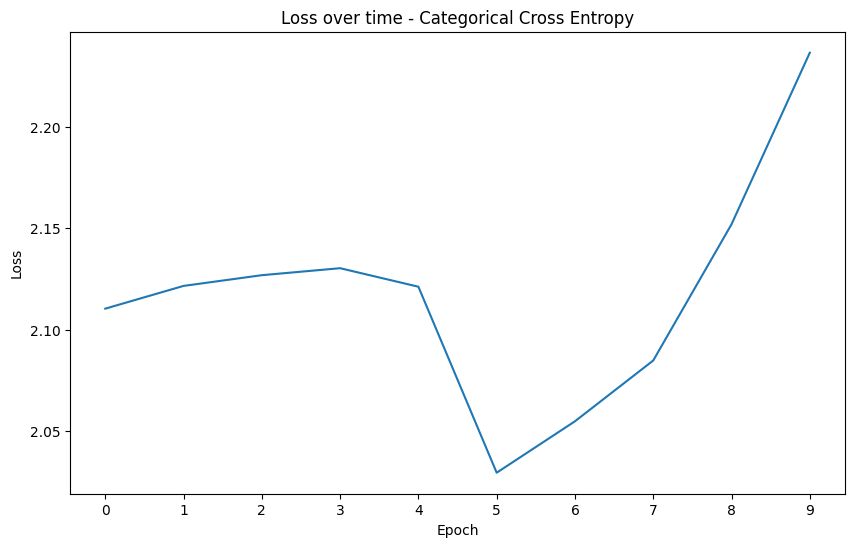

In [23]:
plot_loss(nn.losses_tables[0], 'Categorical Cross Entropy')

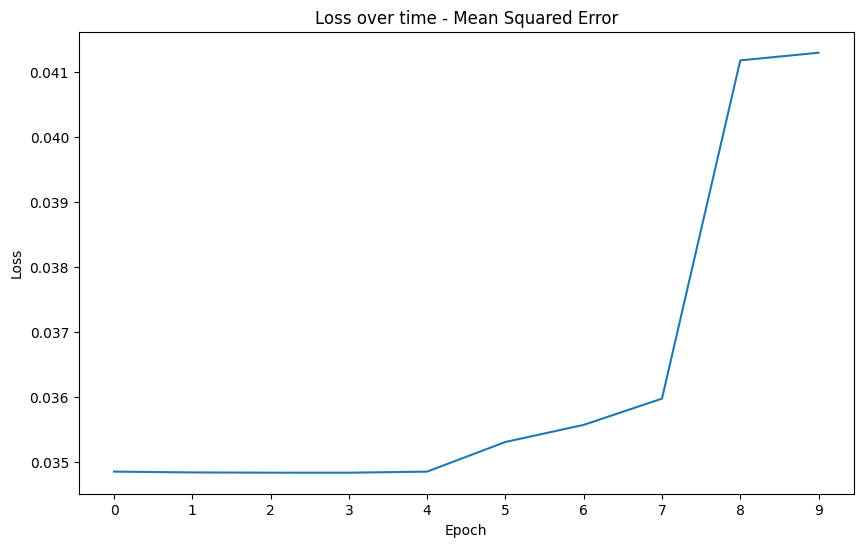

In [24]:
plot_loss(nn.losses_tables[1], 'Mean Squared Error')

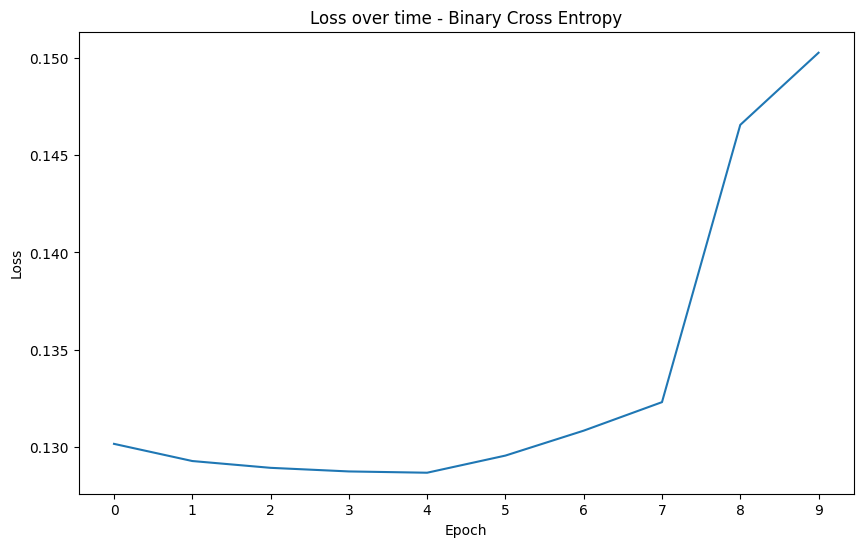

In [25]:
plot_loss(nn.losses_tables[2], 'Binary Cross Entropy')

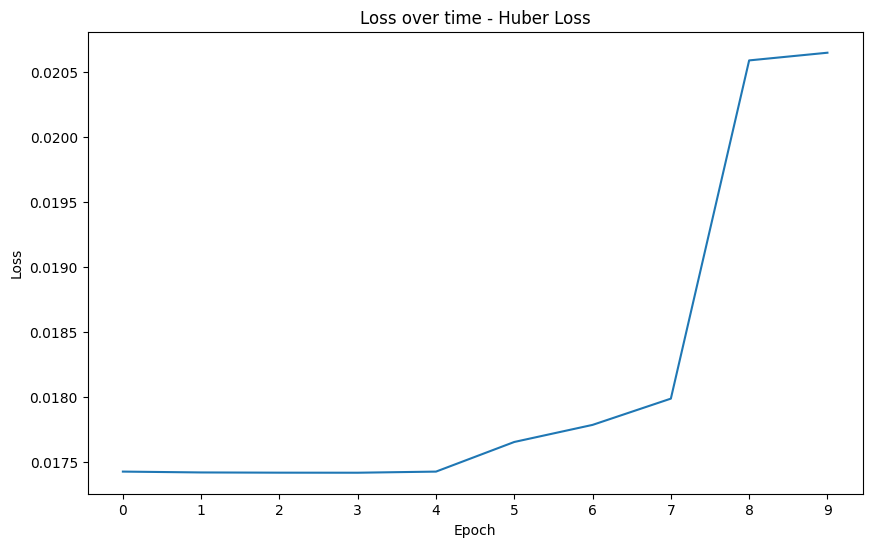

In [26]:
plot_loss(nn.losses_tables[3], 'Huber Loss')   

Wykres ROC dla każdego wyjścia

C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


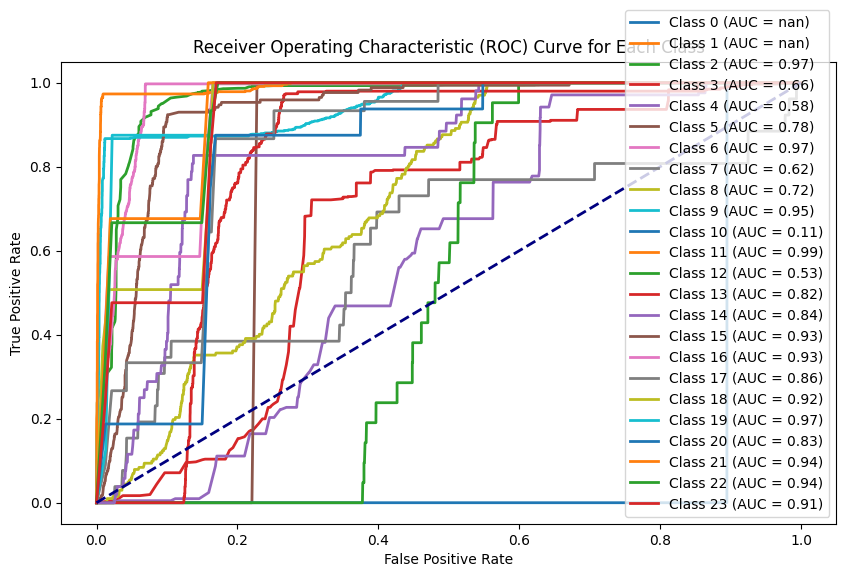

In [27]:
nn.plot_roc_curves_multi_label(X_test, y_test)

Heatmapa porównująca dokładność od współczynnika uczenia się i liczby iteracji

In [28]:
def accuracy_lr_ep_heatmap(learning_rates, epochs):
    accuracy_matrix = np.zeros((len(learning_rates), len(epochs)))
    for i, lr in enumerate(learning_rates):
        for j, ep in enumerate(epochs):
            nn = NeuralNetwork([X.shape[1], 100, Y.shape[1]], lr)
            nn.train(X_train, y_train, ep)
            predictions = nn.forward_pass(X_test)
            best_predictions = np.zeros_like(predictions)
            best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

            accuracy_matrix[i, j] = metrics.accuracy_score(y_test, best_predictions)

    plt.figure(figsize=(10, 6))
    sns.heatmap(accuracy_matrix, annot=True, xticklabels=epochs, yticklabels=learning_rates, fmt='.2f', cmap='Blues')
    plt.xlabel('Number of epochs')
    plt.ylabel('Learning rate')
    plt.title('Accuracy heatmap')
    plt.xticks(np.arange(len(epochs)), epochs)
    plt.yticks(np.arange(len(learning_rates)), learning_rates)
    plt.show()


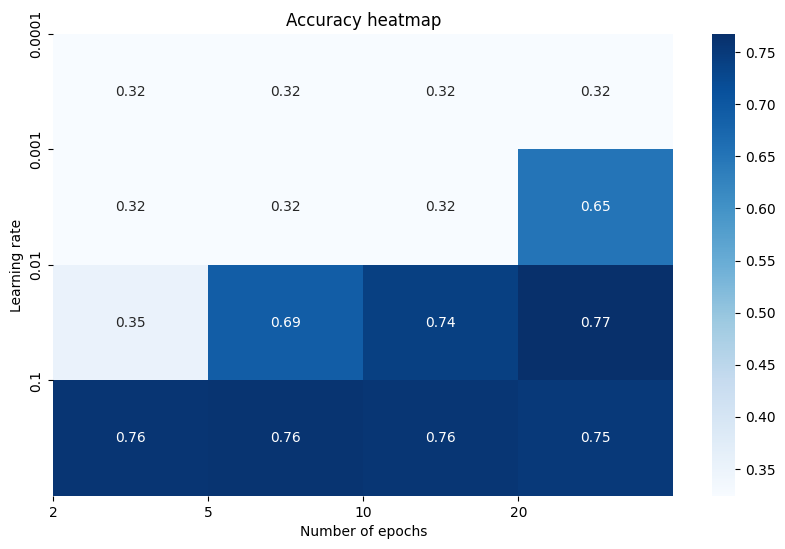

In [29]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = [2, 5, 10, 20]


accuracy_lr_ep_heatmap(learning_rates, epochs)


Algorytm potrzebuje odpowiednio dużej liczby iteracji aby obliczyć dokładne wyniki. Zmniejszając learning rate, musimy zwiększyć liczbę iteracji, aby otrzymać poprawny wynik.

Zauważyć możemy, że przy użyciu dużego współczynnika uczenia się jesteśmy w stanie otrzymać wysoką dokładność już przy tylku 2 iteracjach

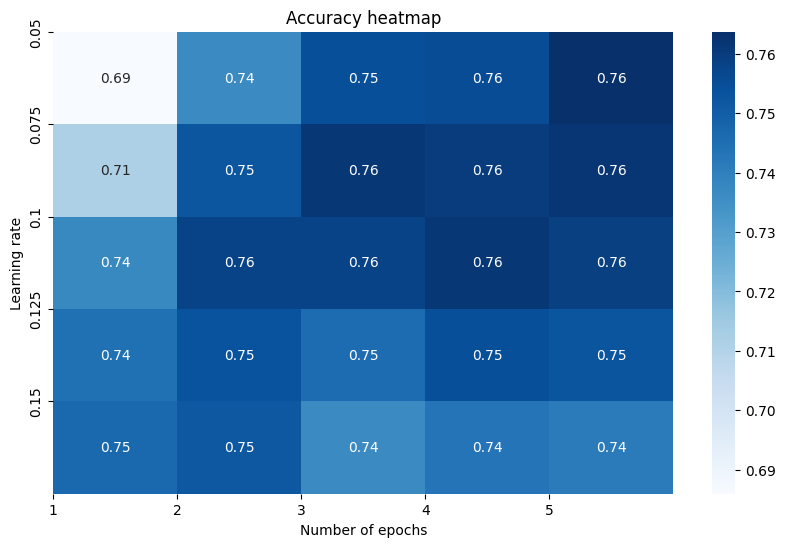

In [35]:
learning_rates = [0.05, 0.075, 0.1, 0.125, 0.15]
epochs = [1, 2, 3, 4, 5]

accuracy_lr_ep_heatmap(learning_rates, epochs)

Macierz sprawdzająca mniejsze wartości learning rate'u i liczby iteracji pokazuje, że najdokładniejsze wyniki znajdują się na prostej której stosunek $lr/ep\approx 0.025$

In [30]:
def accuracy_lines_plot(learning_rate, epochs, lines):
    accuracy = []
    for line in lines:
        X_shorted = X[:line]
        Y_shorted = Y[:line]
        X_train, X_test, y_train, y_test = train_test_split(X_shorted, Y_shorted, test_size=0.2, random_state=0)
        nn = NeuralNetwork([X.shape[1], 100, Y.shape[1]], learning_rate)
        nn.train(X_train, y_train, epochs)
        predictions = nn.forward_pass(X_test)
        best_predictions = np.zeros_like(predictions)
        best_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1

        accuracy.append(metrics.accuracy_score(y_test, best_predictions))

    plt.figure(figsize=(10, 6))
    plt.plot(lines, accuracy)
    plt.xlabel('Number of data lines')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different number of test data')
    plt.show()

Wykres dokładności w zależności od liczby linii danych

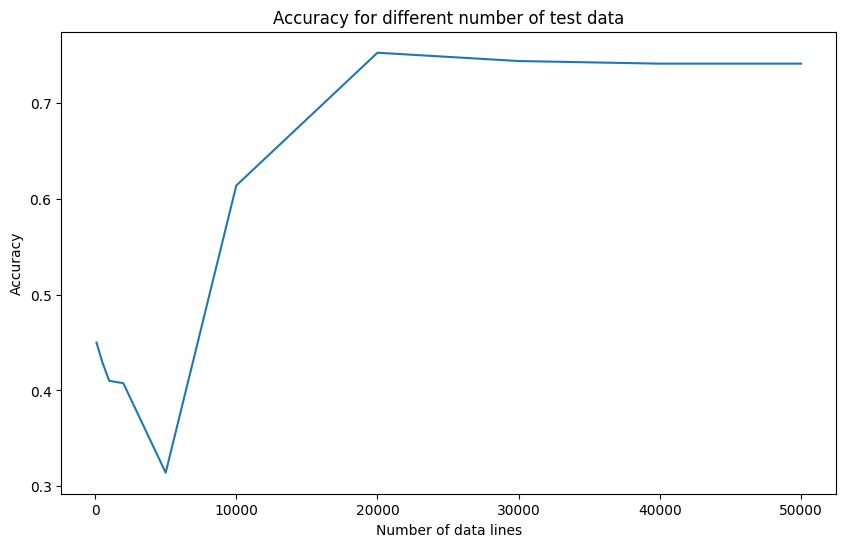

In [31]:
lines = [100, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]
accuracy_lines_plot(0.01, 10, lines)

In [32]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100, alpha=0.01, solver='sgd')
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print('Our model:')
print('Accuracy: ', metrics.accuracy_score(y_test, best_predictions))
print('Precision: ', metrics.precision_score(y_test, best_predictions, average='weighted'))

print('Sklearn model:')
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_sklearn))
print('Precision: ', metrics.precision_score(y_test, y_pred_sklearn, average='weighted'))

Our model:
Accuracy:  0.6977618315393815
Precision:  0.5781674036595329
Sklearn model:
Accuracy:  0.7122842986502648
Precision:  0.6986181525948529


C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\milos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

Nasz model osiąga podobną dokładność, jesteśmy w stanie ją zwiększyć zmieniając odpowiednie hiperparametry